shape of s: (10000, 2)


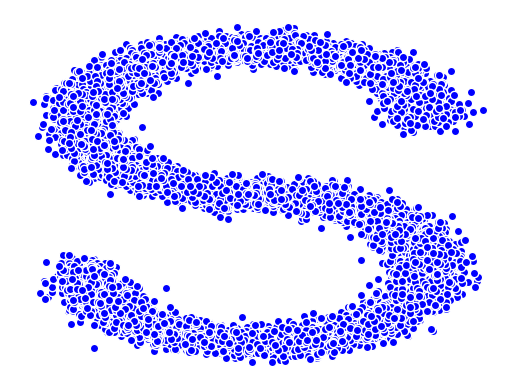

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

s_curve,_ = make_s_curve(10**4,noise=0.1)
s_curve = s_curve[:,[0,2]]/10.0

print("shape of s:",np.shape(s_curve))

data = s_curve.T

fig,ax = plt.subplots()
ax.scatter(*data,color='blue',edgecolor='white')

ax.axis('off')

dataset = torch.Tensor(s_curve).float().to(device)

2、确定超参数的值

In [32]:
num_steps = 100

#制定每一步的beta
betas = torch.linspace(-6,6,num_steps).to(device)
betas = torch.sigmoid(betas)*(0.5e-2 - 1e-5)+1e-5

#计算alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt等变量的值
alphas = 1-betas
alphas_prod = torch.cumprod(alphas,0)
alphas_prod_p = torch.cat([torch.tensor([1]).float().to(device),alphas_prod[:-1]],0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


3、确定扩散过程任意时刻的采样值

In [33]:
#计算任意时刻的x采样值，基于x_0和重参数化
def q_x(x_0,t):
    """可以基于x[0]得到任意时刻t的x[t]"""
    noise = torch.randn_like(x_0).to(device)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)#在x[0]的基础上添加噪声
    

4、演示原始数据分布加噪100步后的结果

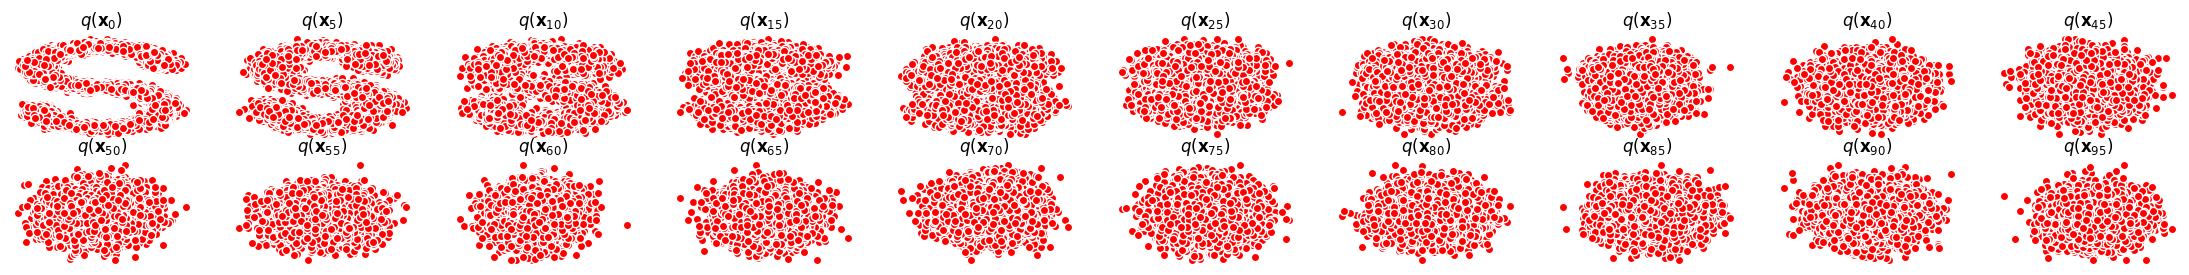

In [35]:
num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='black')

#共有10000个点，每个点包含两个坐标
#生成100步以内每隔5步加噪声后的图像
for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows]))#生成t时刻的采样数据
    q_i = q_i.cpu().detach().numpy()
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

5、编写拟合逆扩散过程高斯分布的模型

In [36]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self,n_steps,num_units=128):
        super(MLPDiffusion,self).__init__()
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
            ]
        )
    def forward(self,x,t):
#         x = x_0
        for idx,embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
            
        x = self.linears[-1](x)
        
        return x

6、编写训练的误差函数

In [37]:
def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps,device):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]
    
    #对一个batchsize样本生成随机的时刻t
    t = torch.randint(0,n_steps,size=(batch_size//2,)).to(device)
    t = torch.cat([t,n_steps-1-t],dim=0)
    t = t.unsqueeze(-1)
    
    #x0的系数
    a = alphas_bar_sqrt[t].to(device)
    
    #eps的系数
    aml = one_minus_alphas_bar_sqrt[t]
    
    #生成随机噪音eps
    e = torch.randn_like(x_0).to(device)
    
    #构造模型的输入
    x = x_0*a+e*aml
    
    #送入模型，得到t时刻的随机噪声预测值
    output = model(x,t.squeeze(-1))
    
    #与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

7、编写逆扩散采样函数（inference）

In [40]:
def p_sample_loop(model,shape,n_steps,betas,one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape).to(device)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor([t]).to(device)
    
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    
    eps_theta = model(x,t)
    
    mean = (1/(1-betas[t]).sqrt())*(x-(coeff*eps_theta))
    
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    
    sample = mean + sigma_t * z
    
    return (sample)

8、开始训练模型，打印loss及中间重构效果

Training model...
tensor(0.8046, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5901, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3770, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2480, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2612, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5185, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3712, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3550, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2492, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2997, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3426, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2336, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5471, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4687, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3559, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3520, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2650

C:\Users\13151\AppData\Local\Temp\ipykernel_25104\183055465.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(1,10,figsize=(28,3))


tensor(0.1835, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3350, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4019, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1488, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2566, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5556, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4488, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2372, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3644, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3157, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5174, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3398, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5133, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3985, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1770, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3086, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5847, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5165, device='cuda:0',

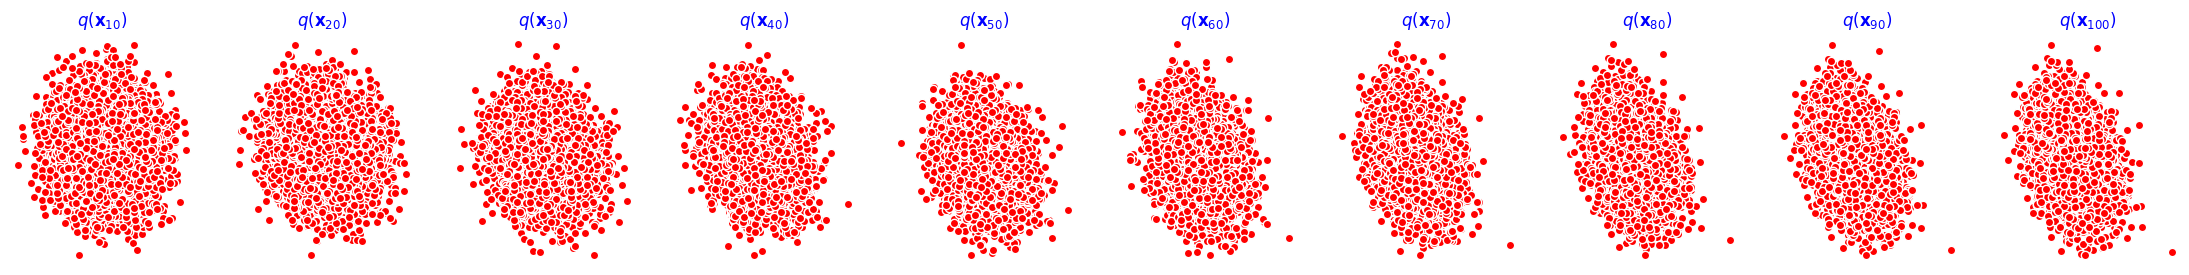

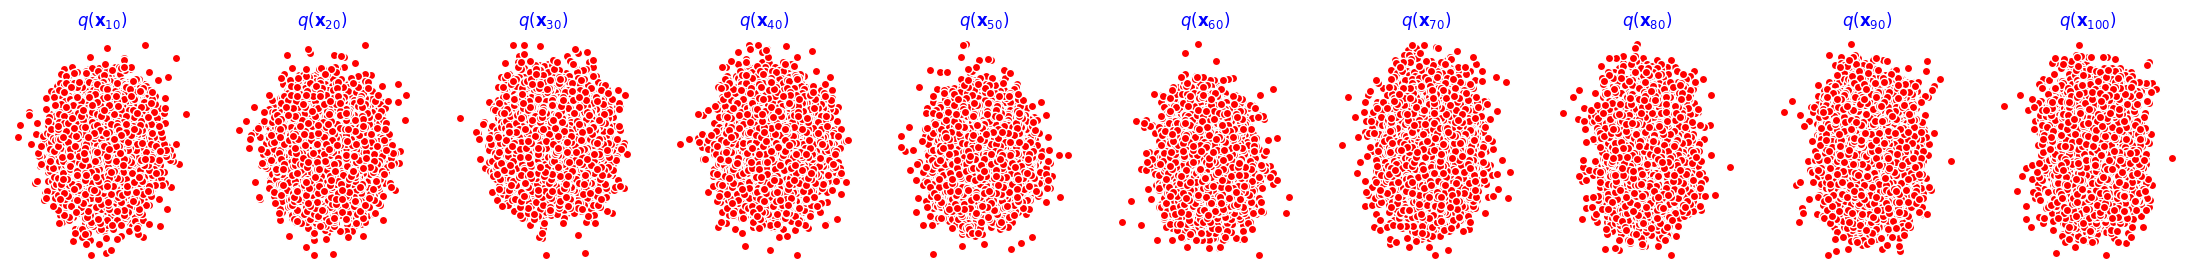

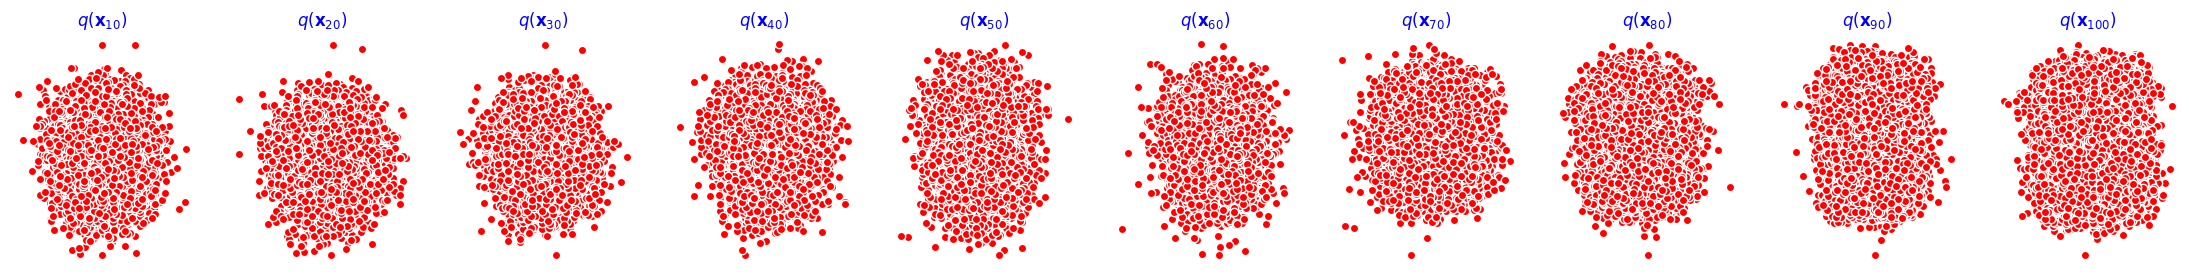

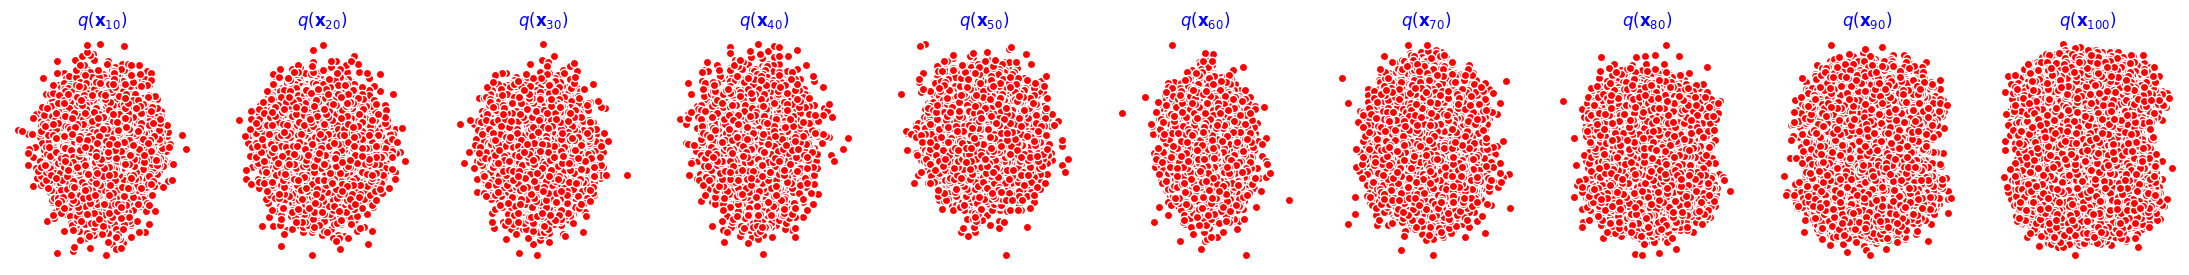

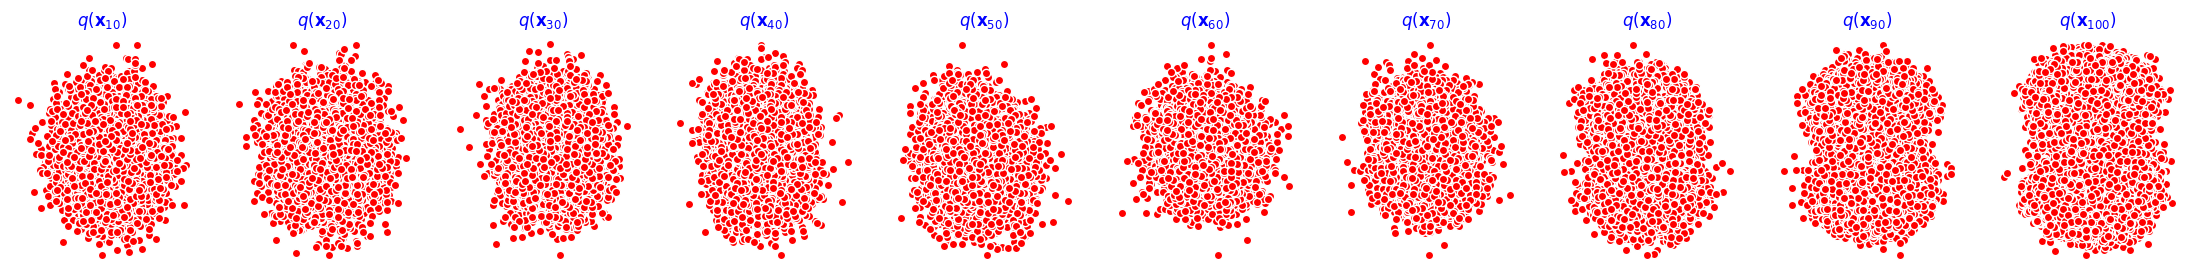

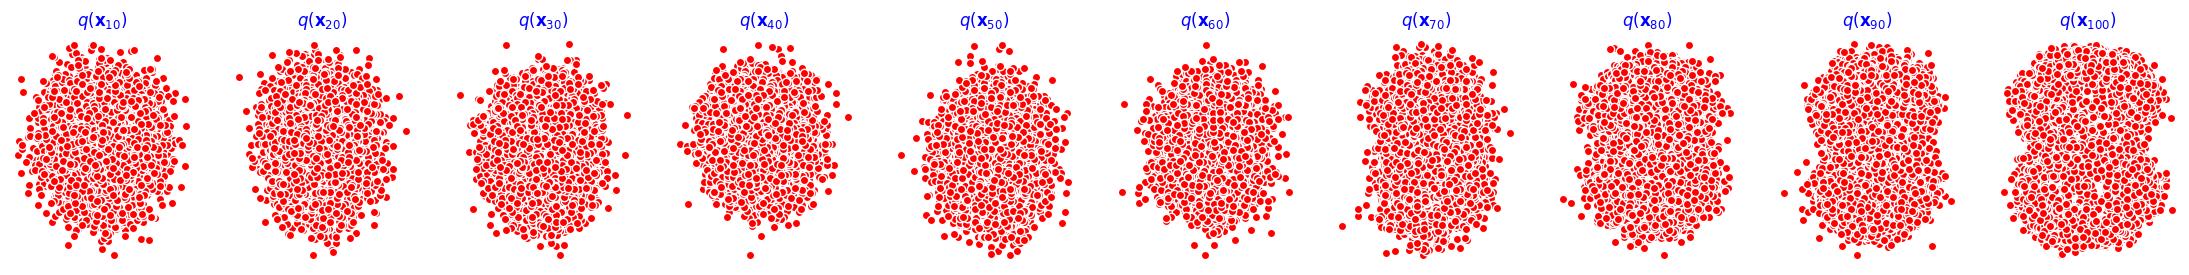

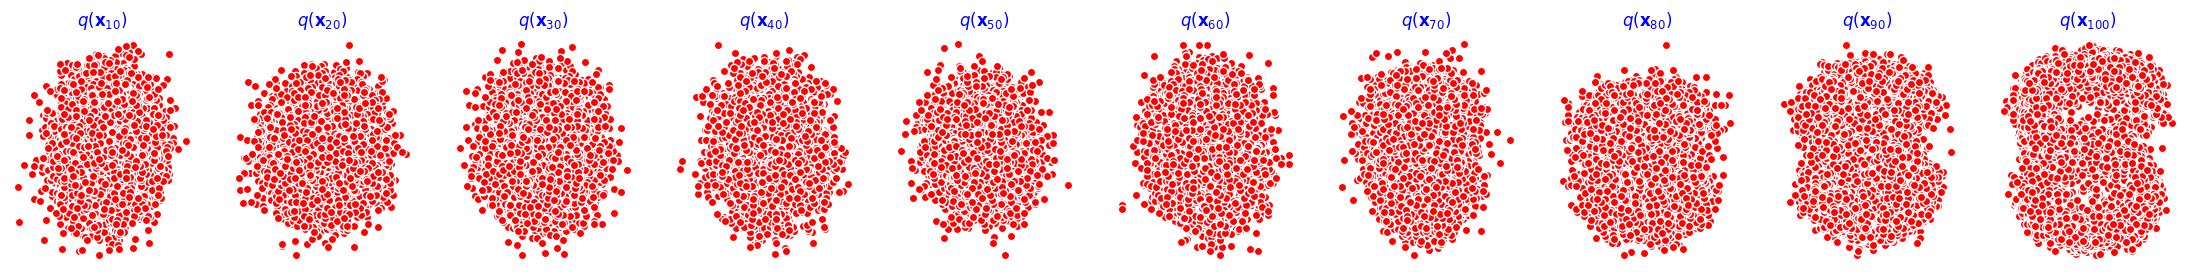

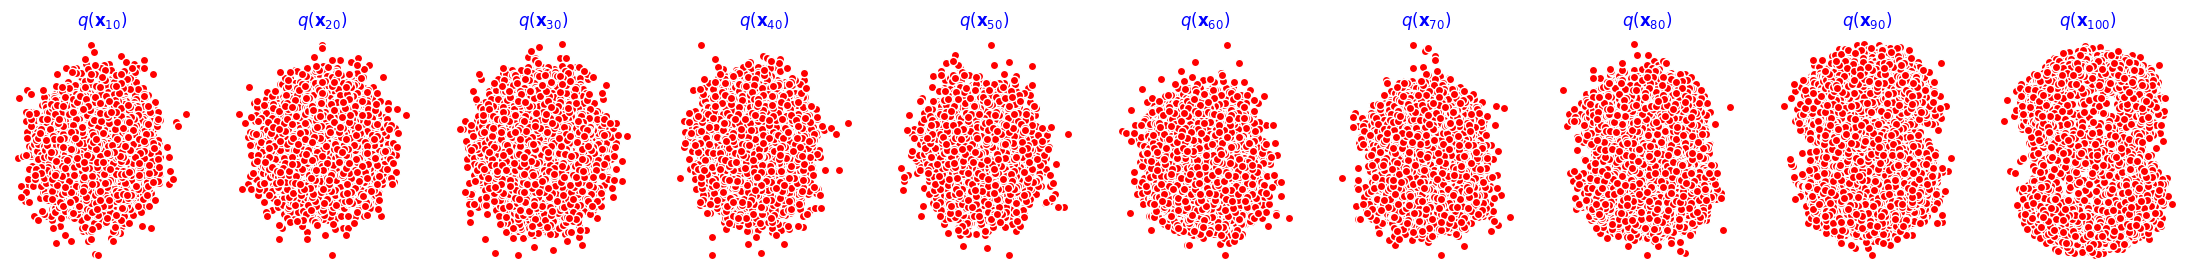

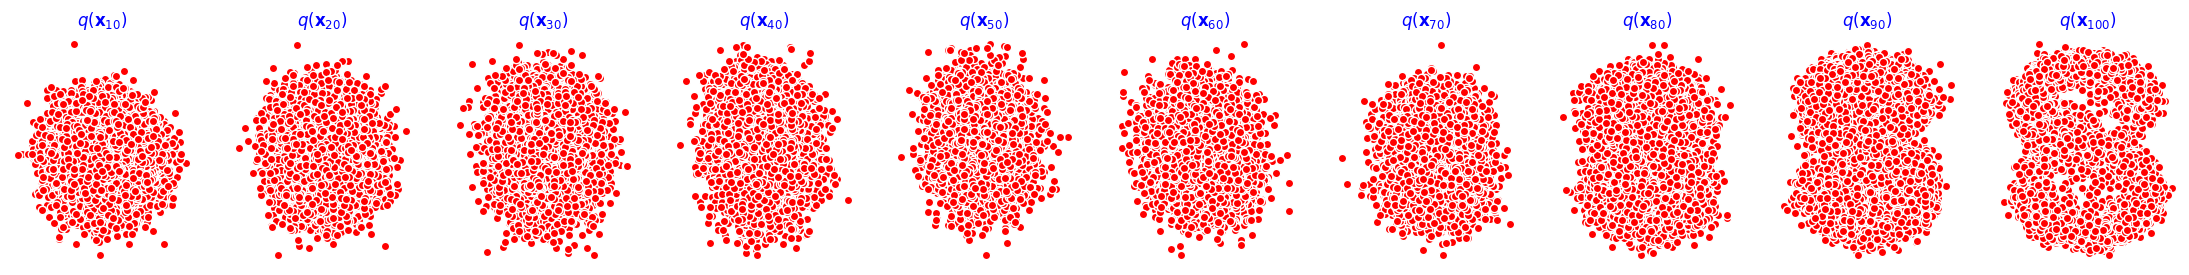

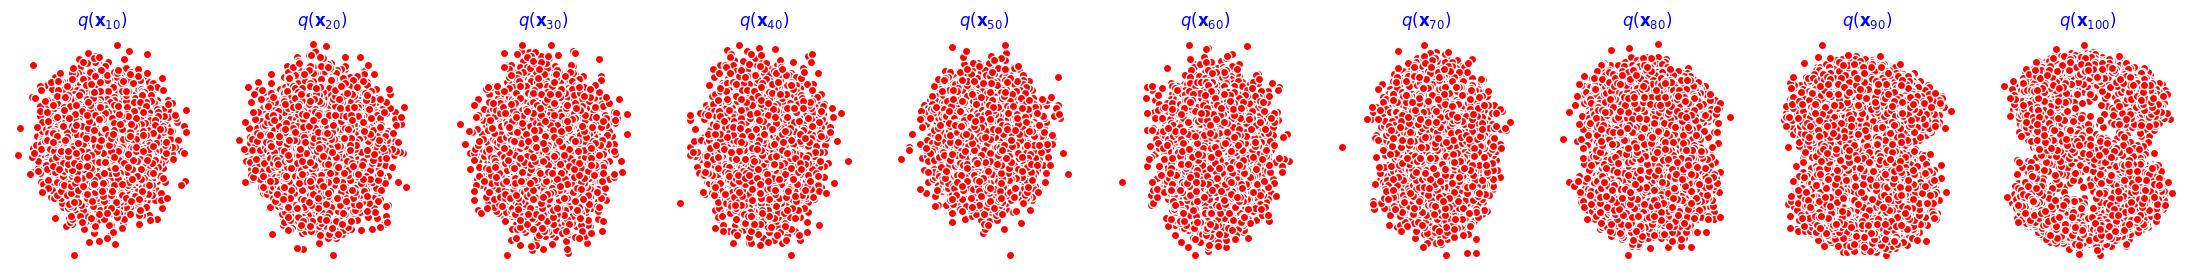

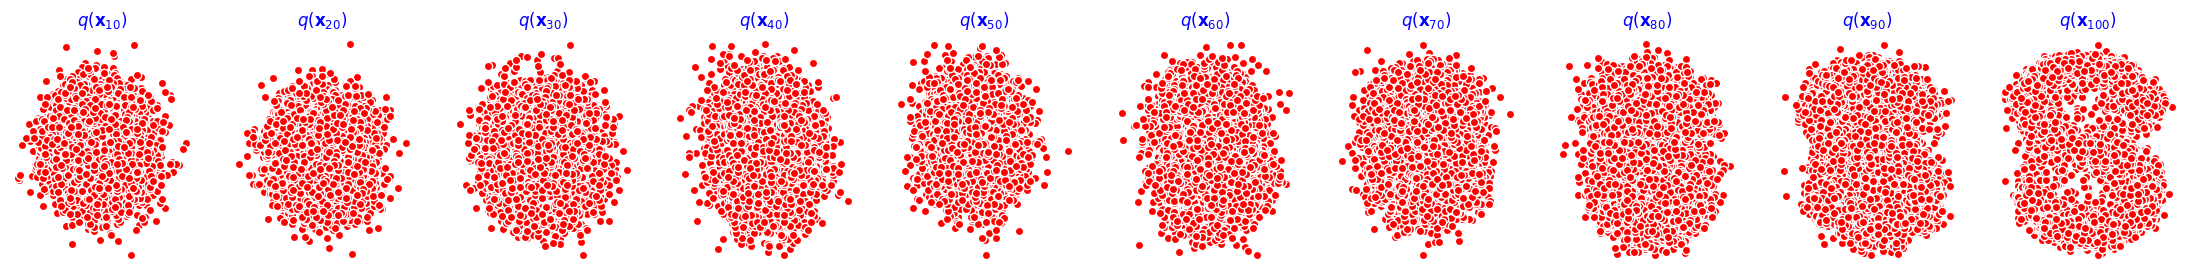

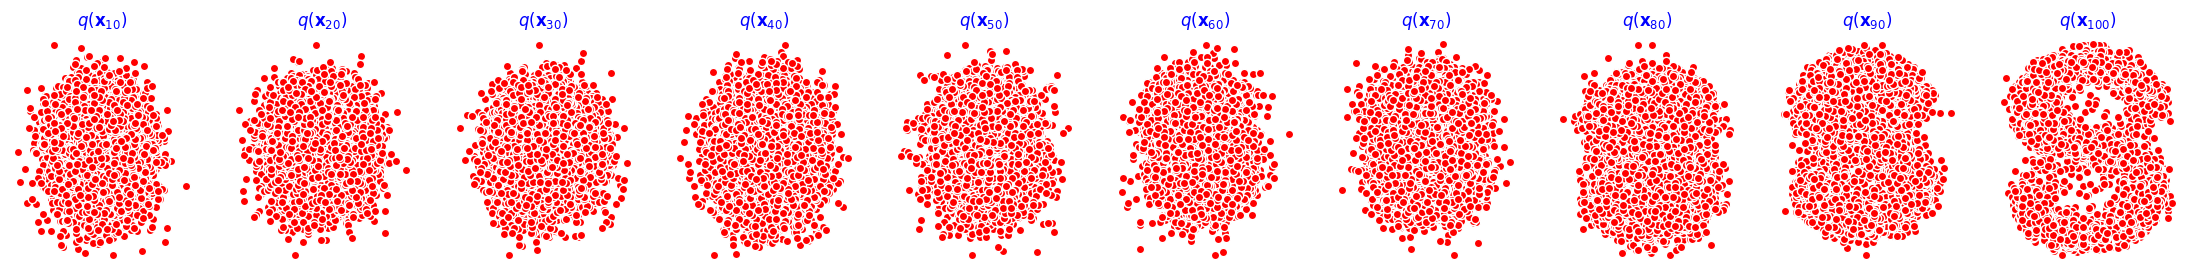

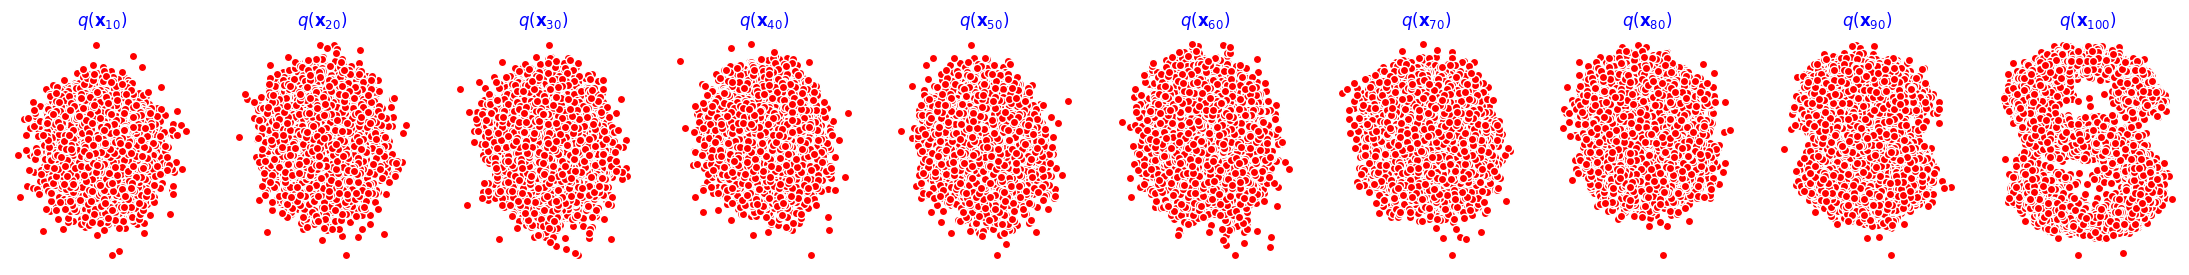

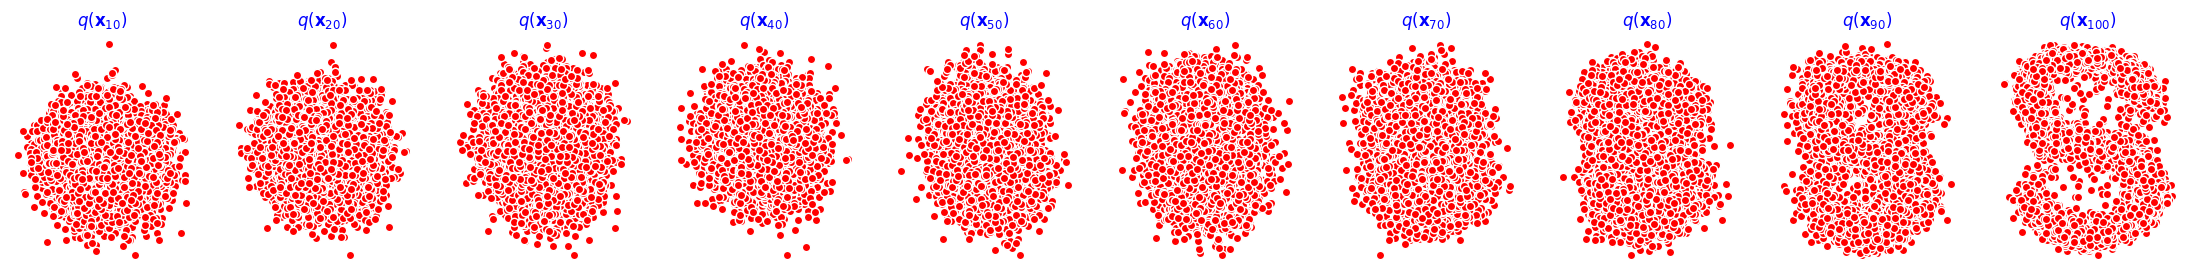

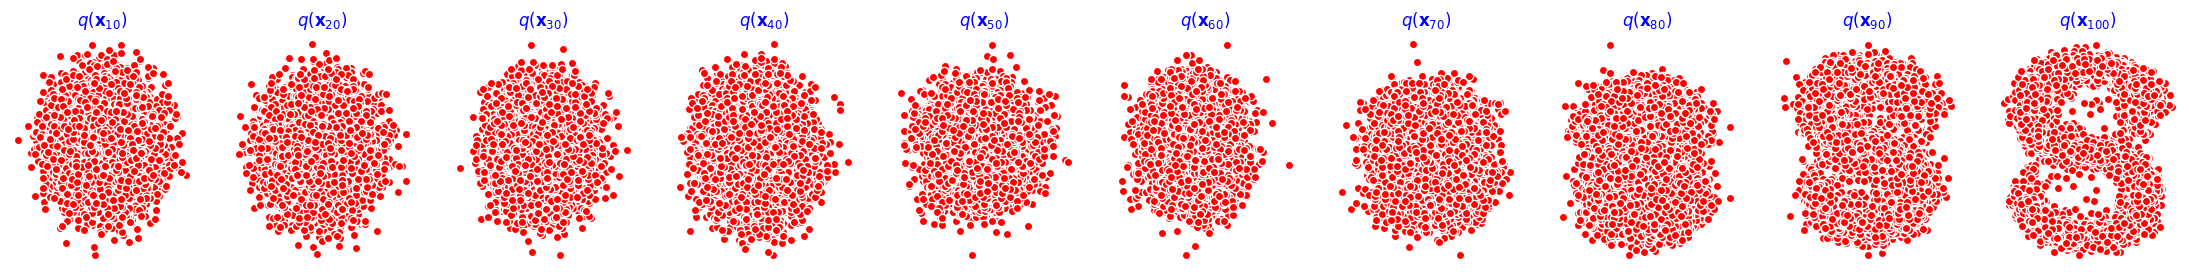

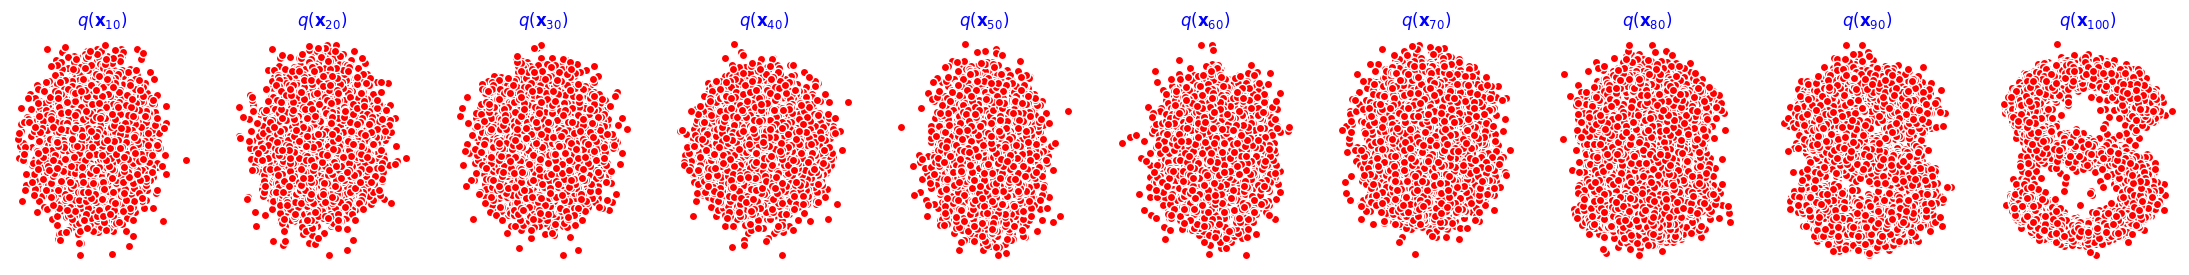

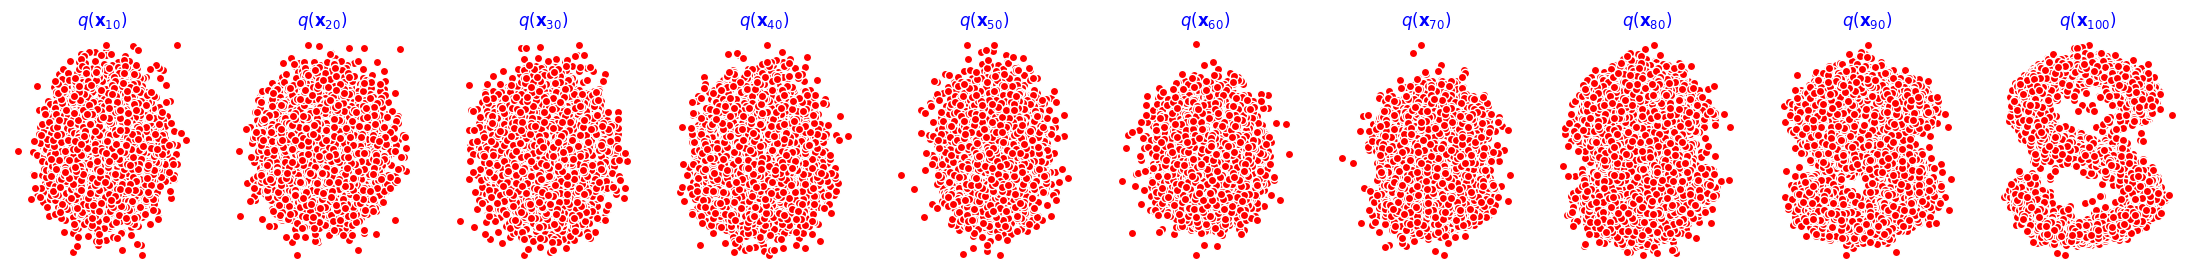

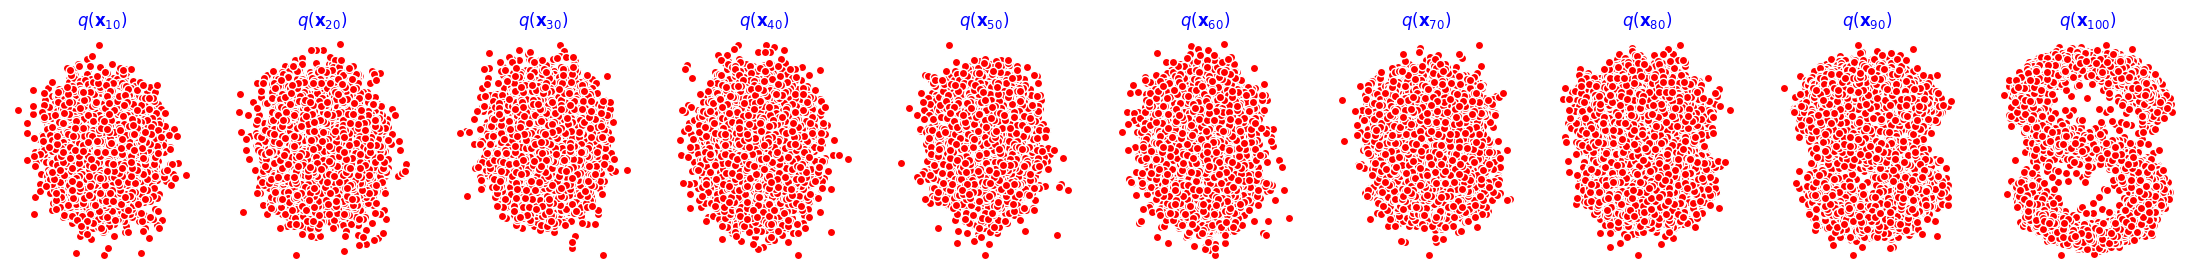

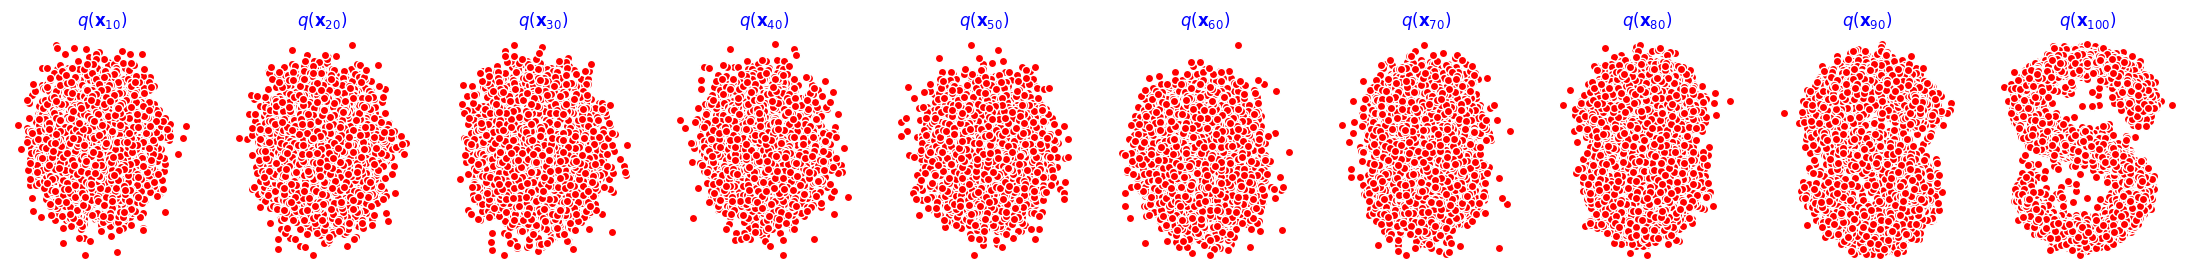

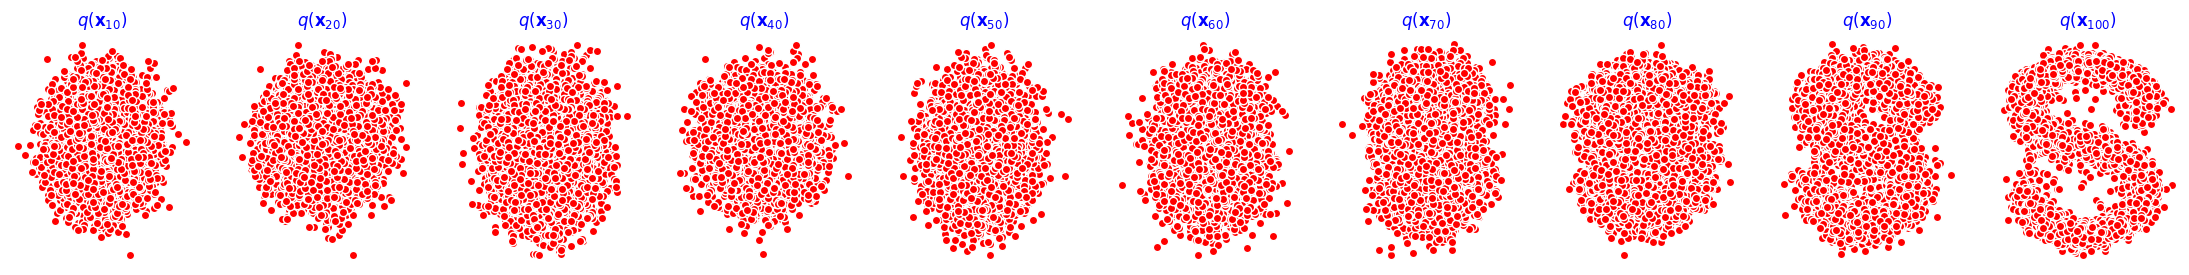

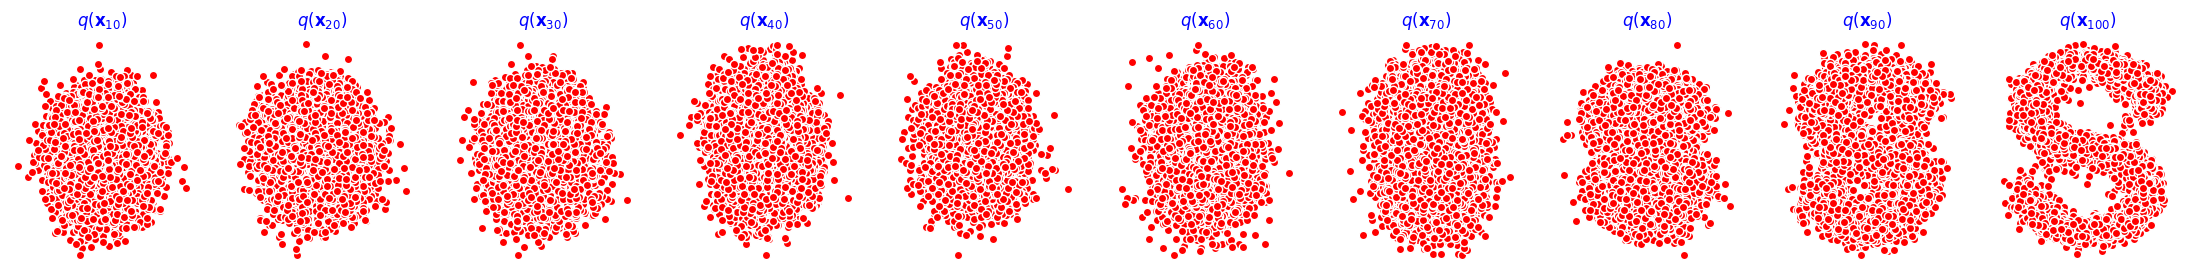

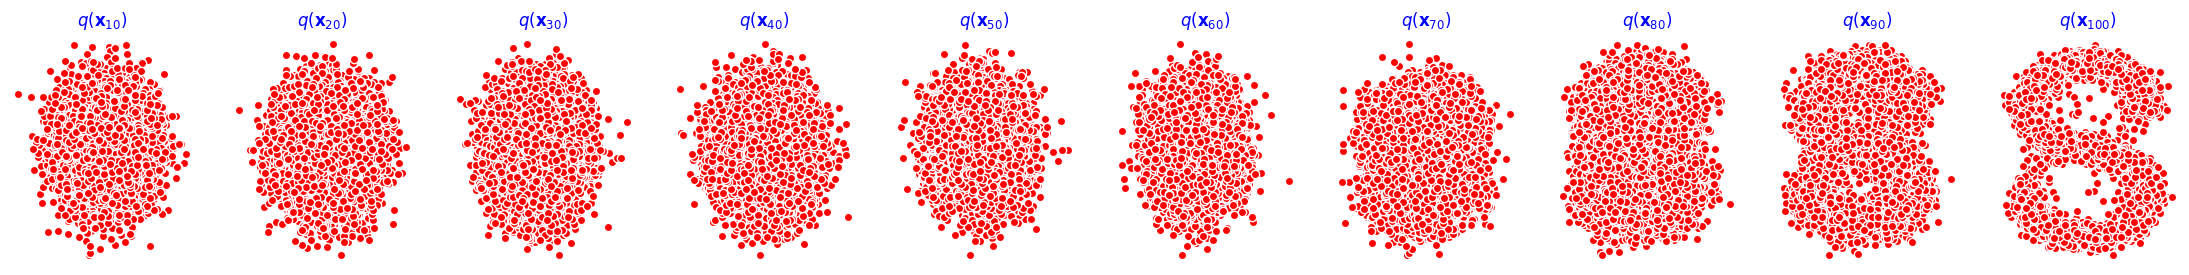

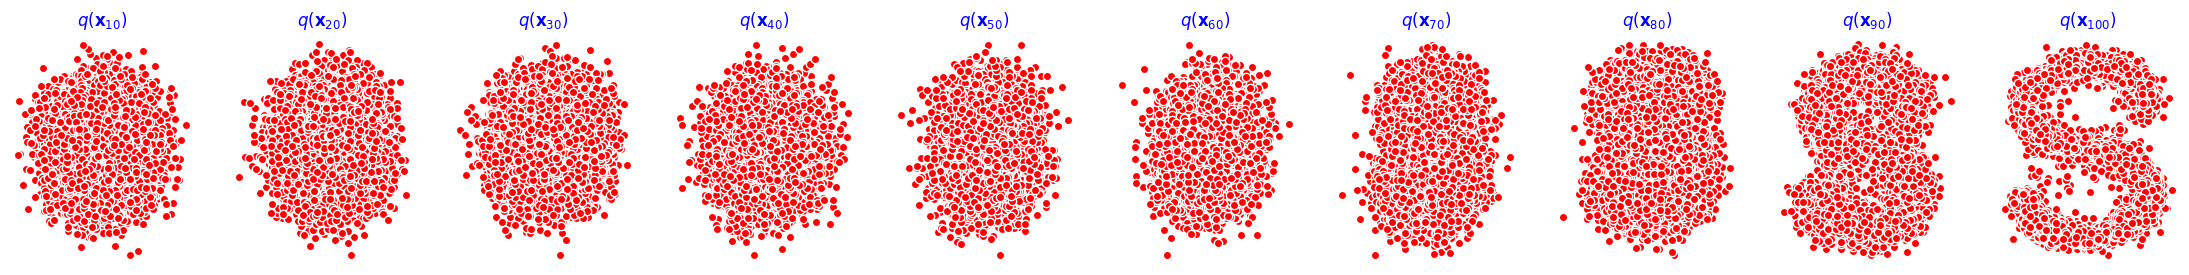

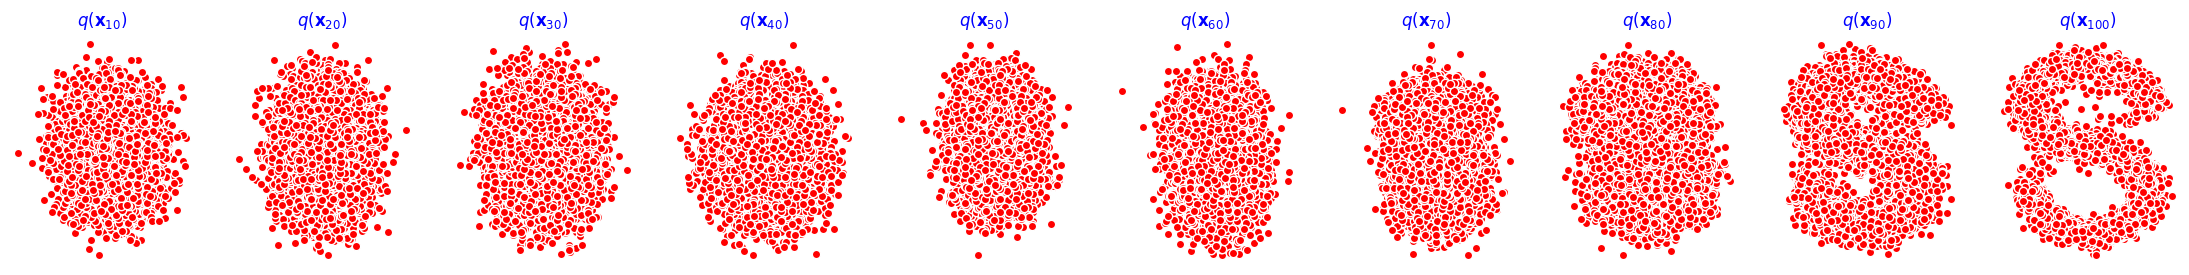

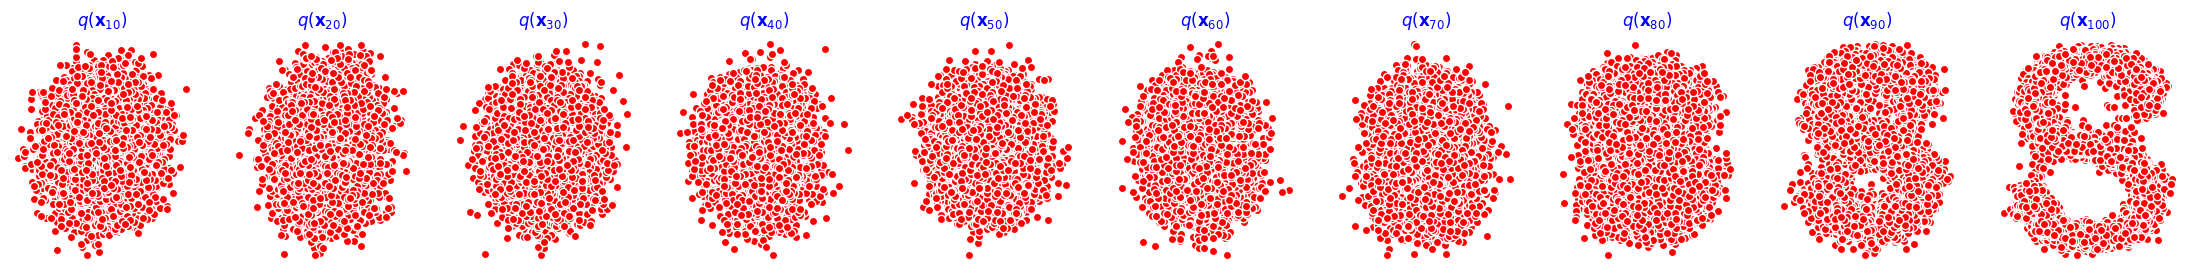

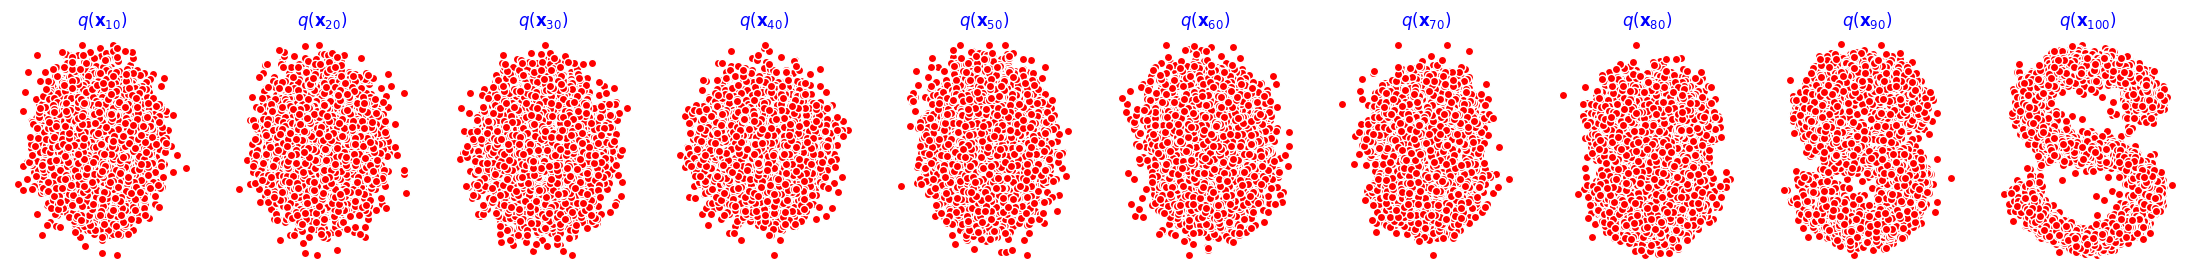

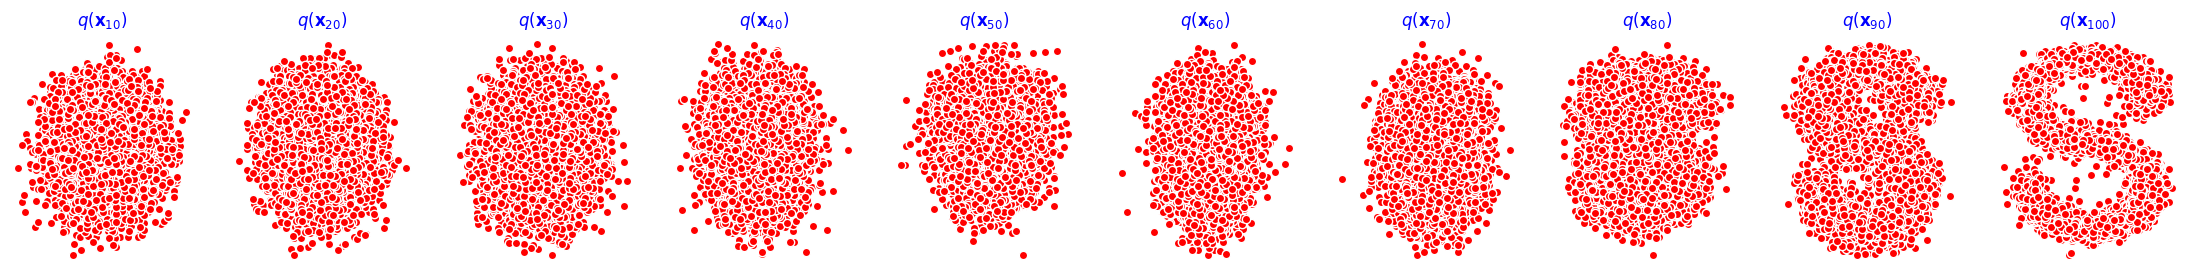

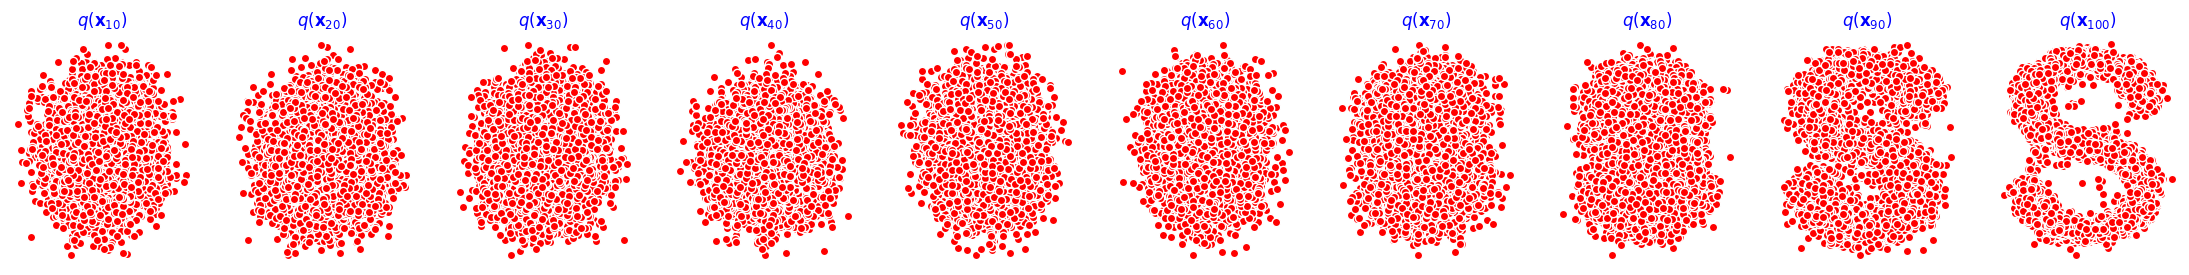

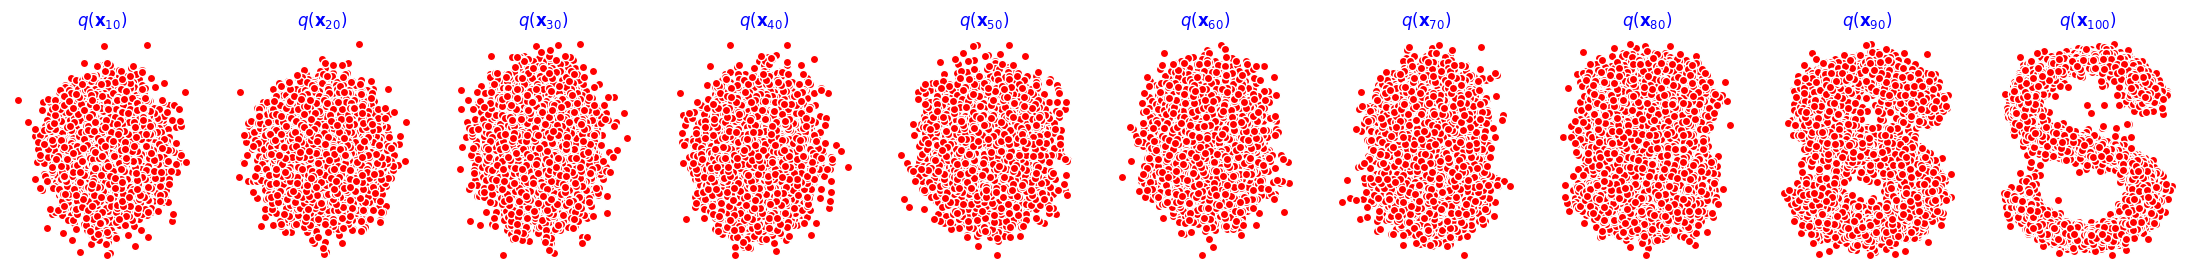

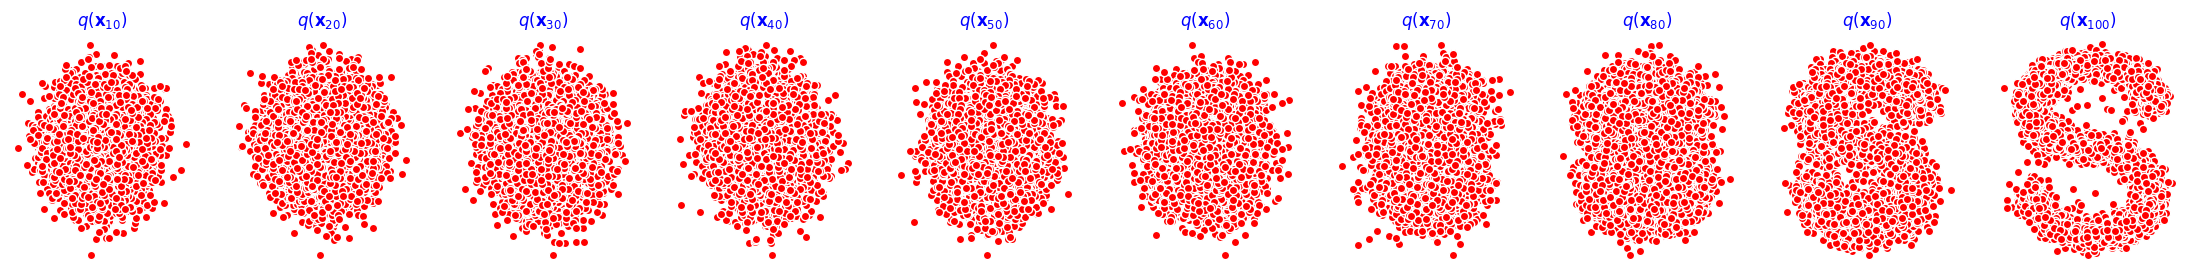

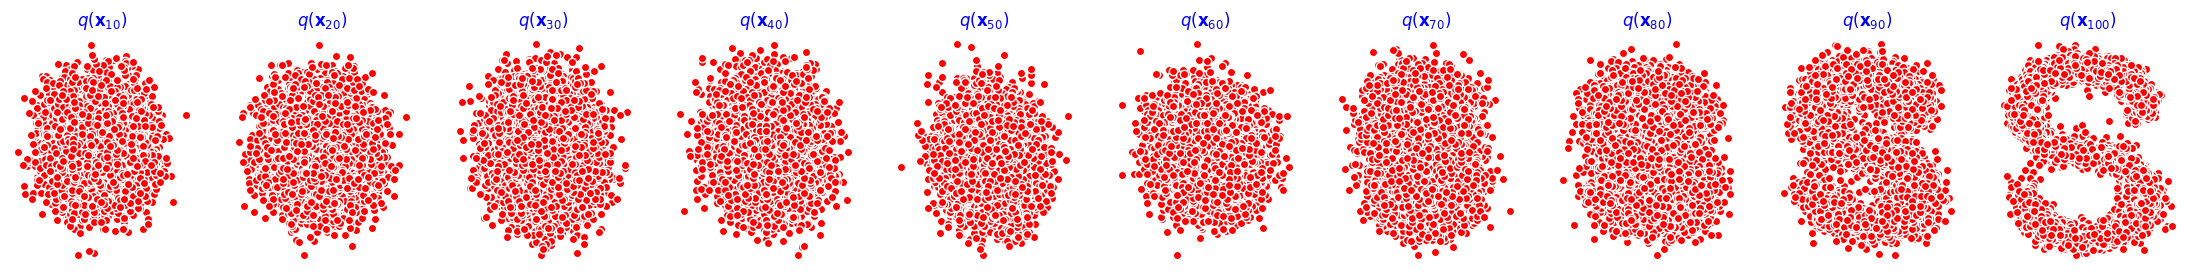

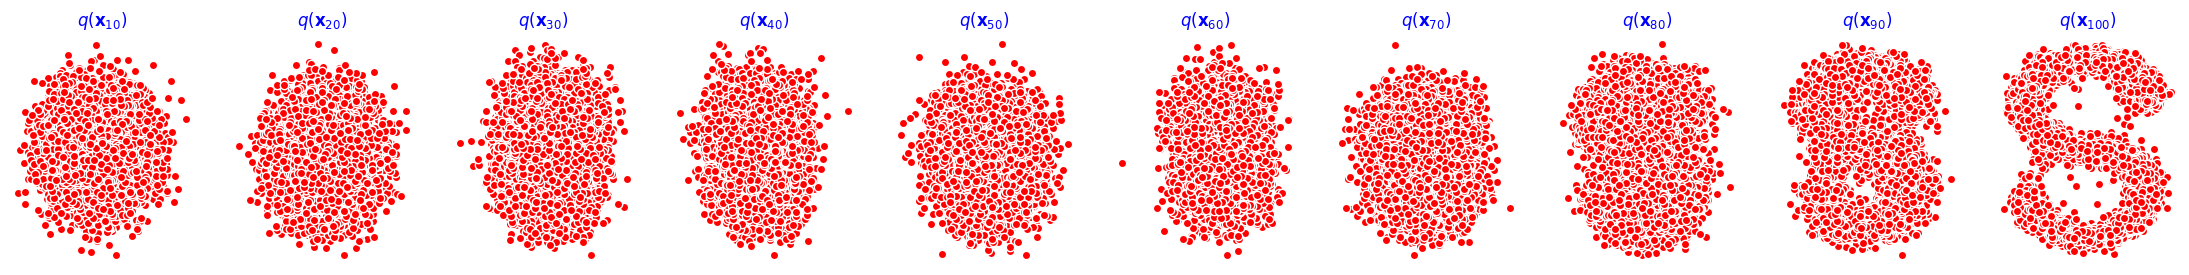

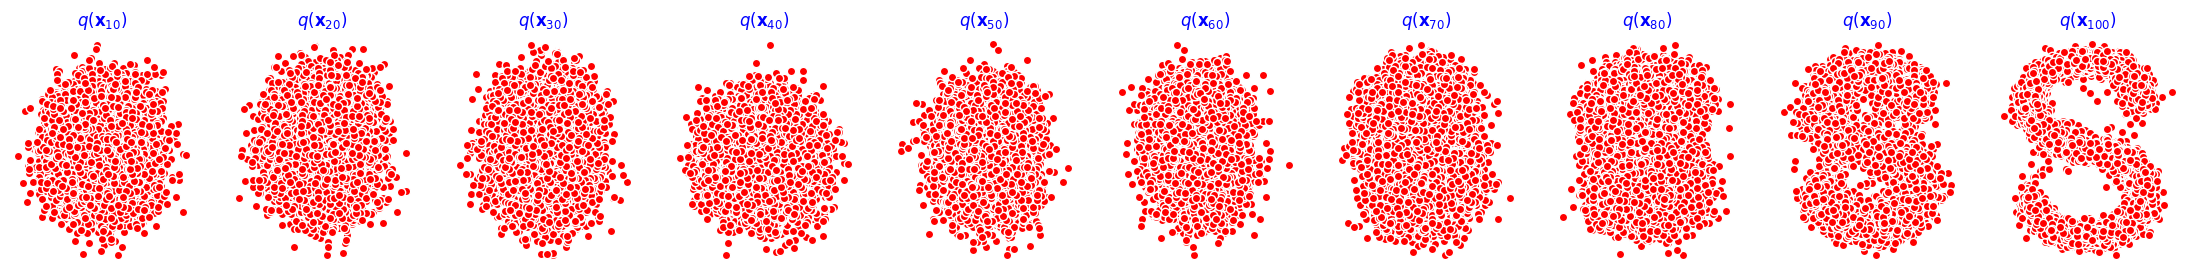

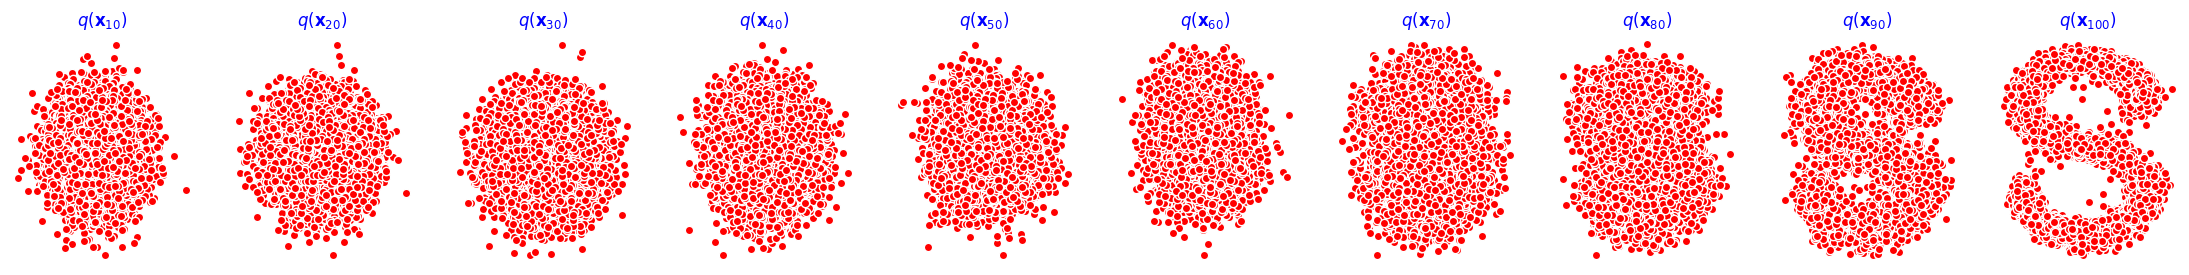

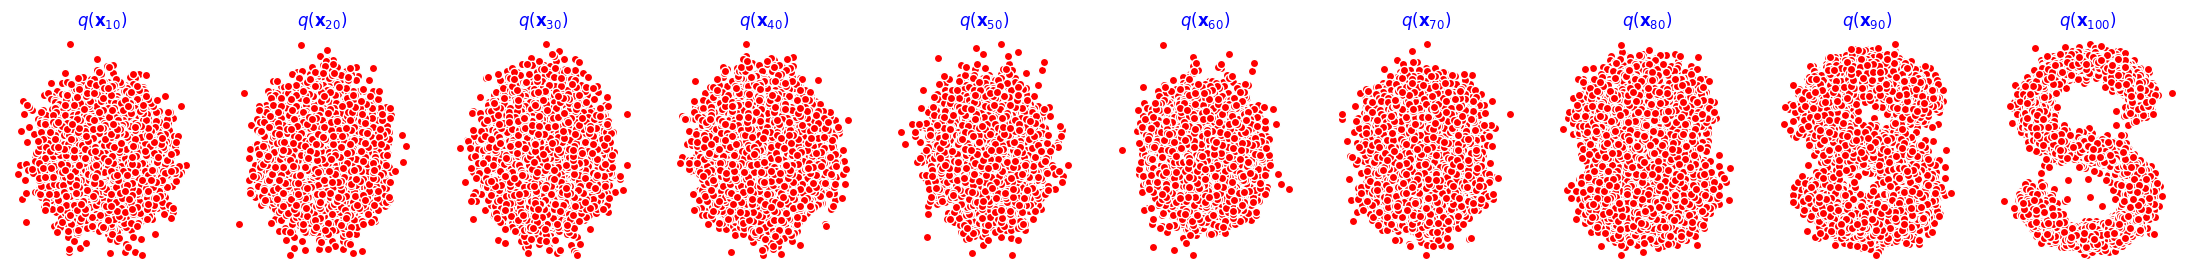

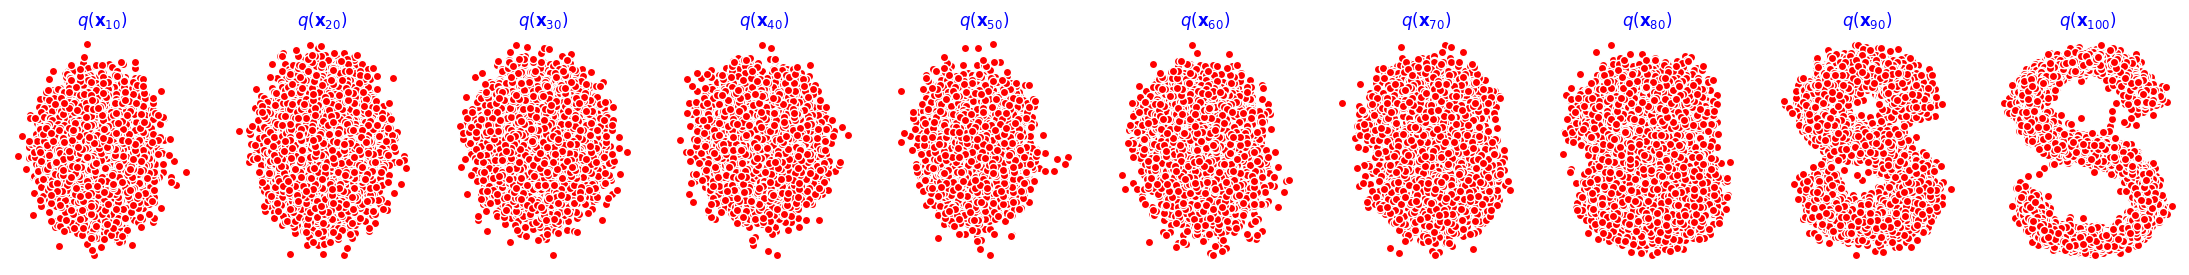

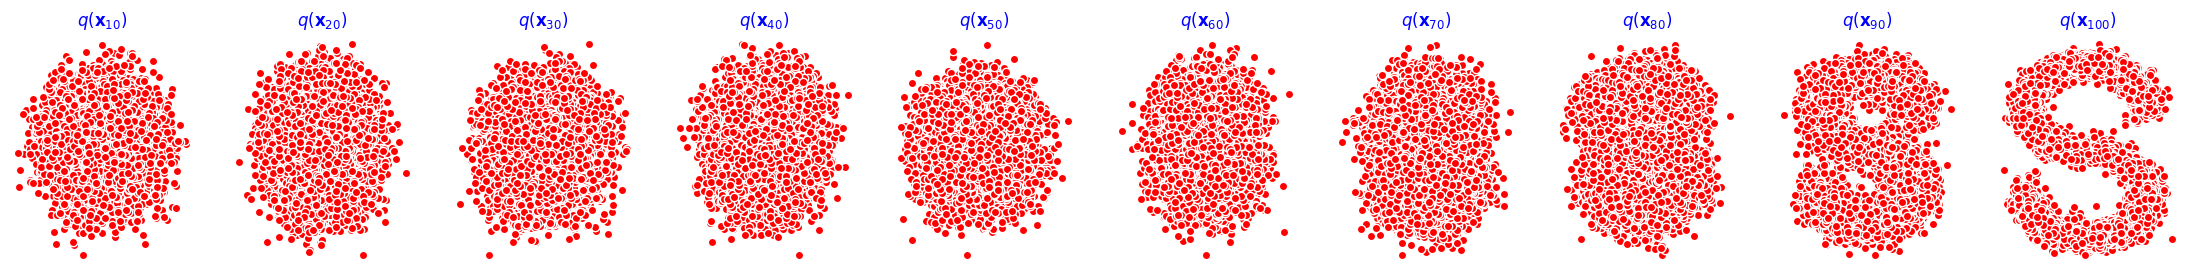

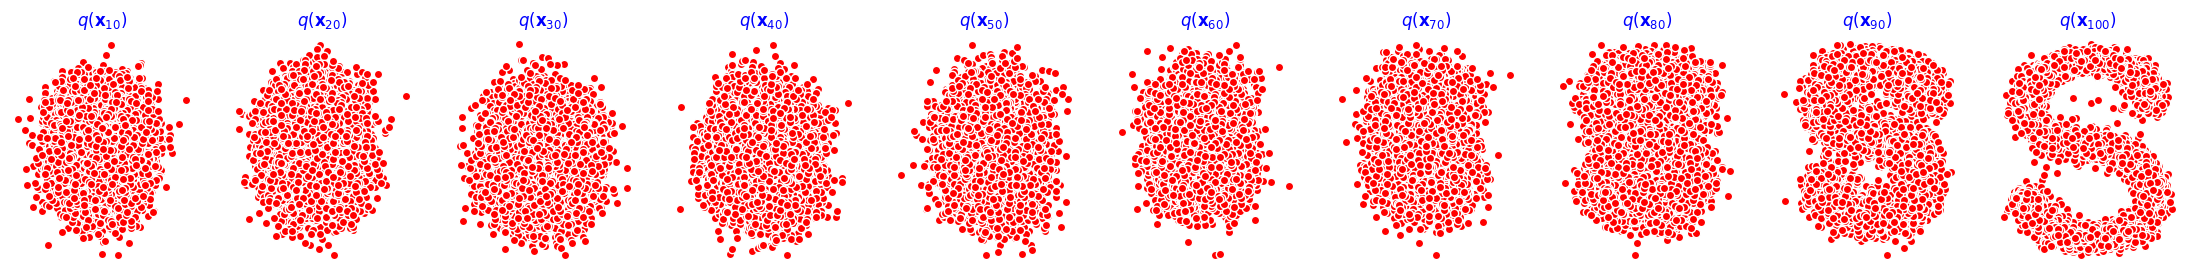

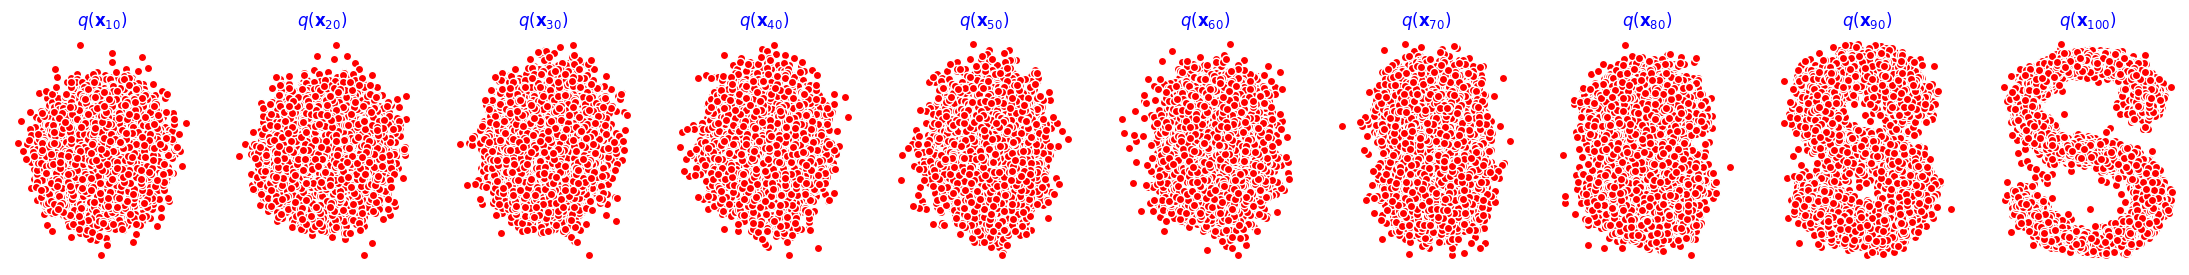

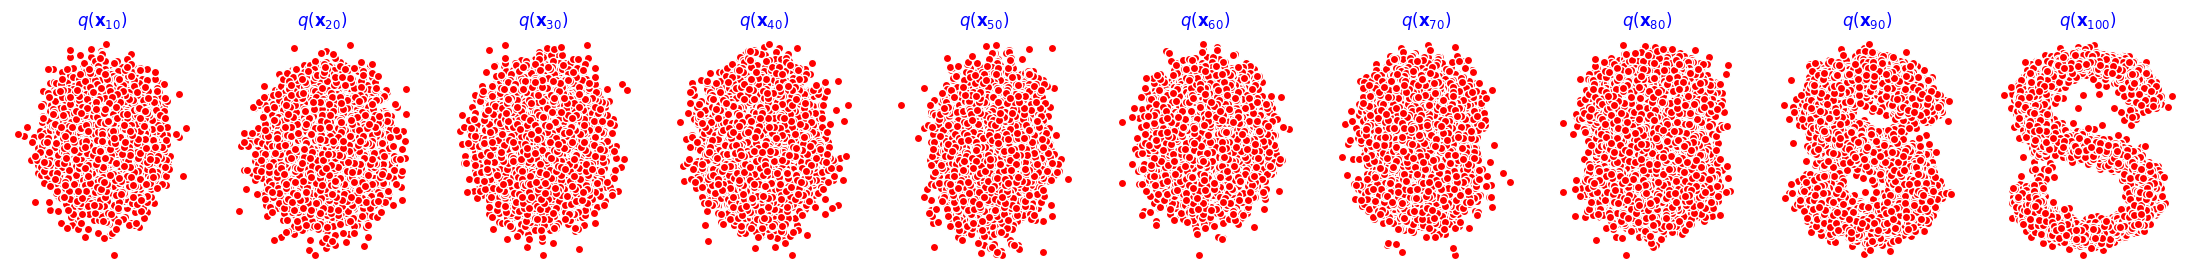

In [42]:
seed = 1234

class EMA():
    """构建一个参数平滑器"""
    def __init__(self,mu=0.01):
        self.mu = mu
        self.shadow = {}
        
    def register(self,name,val):
        self.shadow[name] = val.clone()
        
    def __call__(self,name,x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0-self.mu)*self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average
    
print('Training model...')
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
num_epoch = 4000
plt.rc('text',color='blue')

model = MLPDiffusion(num_steps).to(device)#输出维度是2，输入是x和step
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for t in range(num_epoch):
    for idx,batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps,device)
        optimizer.zero_grad(),
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()
        
    if(t%100==0):
        print(loss)
        x_seq = p_sample_loop(model,dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)
        
        fig,axs = plt.subplots(1,10,figsize=(28,3))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach().cpu().numpy()
            axs[i-1].scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white');
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

9、动画演示扩散过程和逆扩散过程

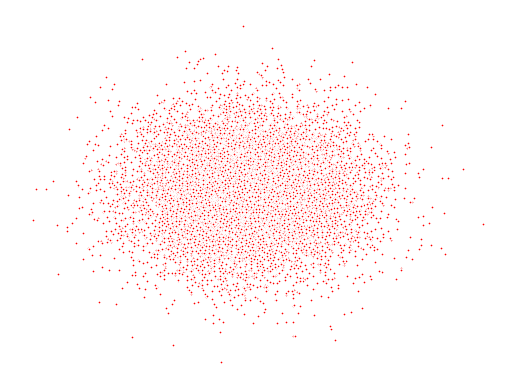

In [45]:
import io
from PIL import Image

imgs = []
for i in range(100):
    plt.clf()
    q_i = q_x(dataset,torch.tensor([i]))
    q_i = q_i.detach().cpu().numpy()
    plt.scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white',s=5);
    plt.axis('off');
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf,format='png')
    img = Image.open(img_buf)
    imgs.append(img)

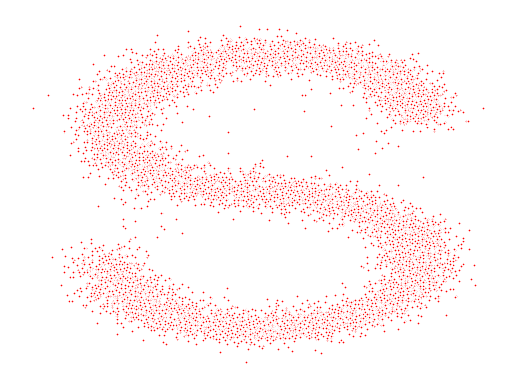

In [47]:
reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach().cpu().numpy()
    plt.scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white',s=5);
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf,format='png')
    img = Image.open(img_buf)
    reverse.append(img)

In [48]:
imgs = imgs +reverse

In [49]:
imgs[0].save("diffusion.gif",format='GIF',append_images=imgs,save_all=True,duration=100,loop=0)